# Makemore 2 - Exercises

Notes on the exercises from the [makemore #2 video](https://www.youtube.com/watch?v=TCH_1BHY58I).<br>
The video description holds the exercises, which are also listed below.<br>
Feel free to try solving on your own first using [this starter notebook](./N003%20-%20Makemore_2_Exercises.ipynb).

1. Watch the [makemore #2 video](https://www.youtube.com/watch?v=TCH_1BHY58I) on YouTube
2. Come back and complete the exercises to level up :)

## Exercise 1 - Beating the Game

**Objective:** Tune the hyperparameters of the training to beat Andrej's best validation loss of $2.2$.<br>
Note that I already solved this in the documenting notebook with a validation loss of $2.15$. I will try to beat my own bar here.

In [1]:
import tqdm
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available

Matplotlib is building the font cache; this may take a moment.


In [2]:
# read in all 32033 words
words = open('../names.txt', 'r').read().splitlines()
print(words[:5]) # show a sample of the first 8 names
print(len(words)) # this many words in total

['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


In [3]:
# build a vocabulary of characters map them to integers
chars = sorted(list(set(''.join(words)))) # set(): Throwing out letter duplicates
stoi = {s:i+1 for i,s in enumerate(chars)} # Make tupels of type (char, counter)
stoi['.'] = 0 # Add this special symbol's entry explicitly
itos = {i:s for s,i in stoi.items()} # Switch order of (char, counter) to (counter, char)

In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print('X:', X.shape, '\tY:', Y.shape)
    return X,Y

random.seed(42)          # for reproducibility
random.shuffle(words)    # words is just the bare list of all names, from wayyy above
n1 = int(0.8*len(words)) # index at 80% of all words (rounded for integer indexing)
n2 = int(0.9*len(words)) # index at 90% of all words (rounded for integer indexing)

print('Training Set:')
Xtr, Ytr = build_dataset(words[:n1])     # The first 80% of all words
print('Validation Set:')
Xdev, Ydev = build_dataset(words[n1:n2]) # The 10% from 80% to 90% of all words
print('Test Set:')
Xte, Yte = build_dataset(words[n2:])     # The 10% from 90% to 100% of all words

Training Set:
X: torch.Size([182625, 3]) 	Y: torch.Size([182625])
Validation Set:
X: torch.Size([22655, 3]) 	Y: torch.Size([22655])
Test Set:
X: torch.Size([22866, 3]) 	Y: torch.Size([22866])


In [97]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g)
W1 = torch.randn((block_size * 20, 200), generator=g)
b1 = torch.randn((200), generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []

18167 parameters


In [98]:
epochs = 400_000

for i in tqdm.tqdm(range(epochs)):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (128,)) # Batch size was 32 before, now 128

    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h1 = torch.tanh(emb.view(-1, block_size * 20) @ W1 + b1) # (32, 300)
    logits = h1 @ W2 + b2 # (32, 50)
    loss = F.cross_entropy(logits, Ytr[ix]) # (32,)

    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    if i < 0.1 * epochs:
      lr = 0.3
    elif i < 0.2 * epochs:
      lr = 0.1
    elif i < 0.4 * epochs:
      lr = 0.06
    else:
      lr = 0.03

    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

# print('Loss for current mini-batch:', loss.item())

100%|██████████| 400000/400000 [09:15<00:00, 720.38it/s]


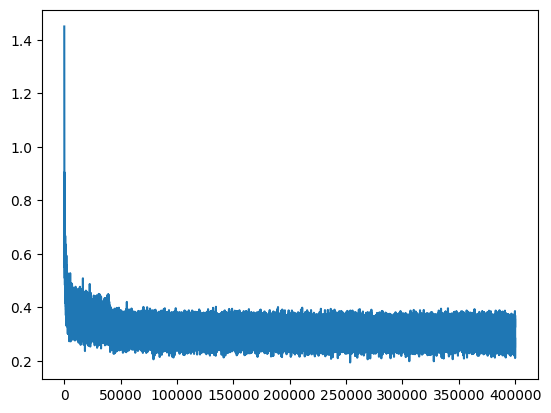

In [99]:
plt.plot(stepi, lossi);

In [100]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * 20) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1354410648345947


I applied the following changes to my model and training setup:
- Increased the head size from $30$ to $60$,
- Increased overall learning rates,
- Added another learning rate scheduling step,
- Increased epoch count from $300\text{k}$ to $400\text{k}$.

This gets us a validation loss of $2.135$.

## Exercise 2 - Weight Initialization

**Objective:** I was not careful with the intialization of the network in this video.<br>
**(1)** What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?<br>
**(2)** Can you tune the initialization to get a starting loss that is much more similar to (1)?

A perfectly uniform setting would attribute a likelihood of $\frac{1}{27}$ for picking any of the possible characters as next character. For the drawing of a single next character, we can calculate the expectable cross entropy loss as: $$-log(\frac{1}{27}) = log(27) \approx \underline{\underline{3.295837}}$$

**Why did I write it like this?**<br>
Generally, [cross-entropy loss is formulated like so](https://www.datacamp.com/tutorial/the-cross-entropy-loss-function-in-machine-learning):
$$L = -\sum_{c=1}^N y_c \cdot log(p_c)$$

where
- $N$ is the count of different characters,
- $y_c$ is the label, the ground truth probability for each possible class $c$,
- $p_c$ is the predicted probability for the sample to be part of class $c$.

The ground truth in our case clearly defines a single character to be the next character. This character class has $y_c = 1$, all others have $y_c = 0$. Therefore, the loss only really is derived from the difference of what $y_c$ on the correct class expects (which is a probability of $1$) versus what the model-assigned as probability $p_c$. And this is where the above writing style came from, because as this is the case for our setup, we can rewrite the cross-entropy loss as:
$$L = -log(p_c)$$

In [102]:
print(f'Actual Initial Loss: {lossi[0]}')

Actual Initial Loss: 1.449777603149414


We happen to get a much better loss, but this indicates that from the start, without any information, the model contains some sort of non-uniform distribution that induces some random bias. We profit from that here, luckily enough, but this is rather uncontrollable behavior we have to overcome first to only then be able to thoroughly adapt the distributions to represent internals of the training data.<br>
In short, we should get rid of this behavior.

An intuitive way to combat unwanted weight distributions is to not give such distributions too large of a stage to occupy in the first place. In other words, we would scale our randomly initialized weights down to reduce the unwanted side effects and start out with fully zero-ed out biases. Unlike zero-ed out weight terms, these bias terms can still easily develop into meaningful expressions during training.

If you want to learn more about this, refer to the documentation notebooks 3 and 5.

Our updated, 'squashed' initialization looks like this now:

In [103]:
scaling_factor = 0.01
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g) * scaling_factor
W1 = torch.randn((block_size * 20, 200), generator=g) * scaling_factor
b1 = torch.zeros((200))
W2 = torch.randn((200, 27), generator=g) * scaling_factor
b2 = torch.zeros((27))  # Zero biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []

18167 parameters


In [104]:
epochs = 400_000

for i in tqdm.tqdm(range(epochs)):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (128,)) # Batch size was 32 before, now 128

    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h1 = torch.tanh(emb.view(-1, block_size * 20) @ W1 + b1) # (32, 300)
    logits = h1 @ W2 + b2 # (32, 50)
    loss = F.cross_entropy(logits, Ytr[ix]) # (32,)

    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    if i < 0.1 * epochs:
      lr = 0.3
    elif i < 0.2 * epochs:
      lr = 0.1
    elif i < 0.4 * epochs:
      lr = 0.06
    else:
      lr = 0.03

    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

100%|██████████| 400000/400000 [09:37<00:00, 692.39it/s]


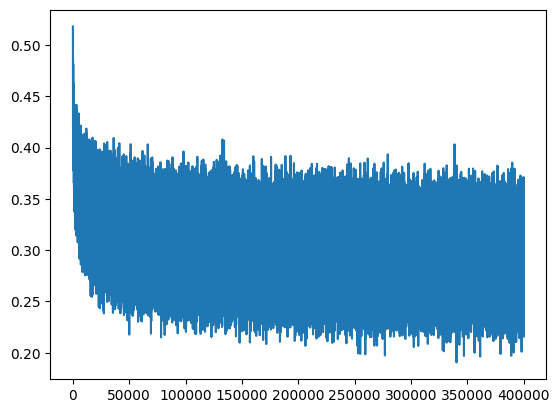

In [105]:
plt.plot(stepi, lossi);

In [106]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * 20) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.107680320739746


## Exercise 3 - A Neural Probabilistic Language Model (Bengio et al. 2003)



**Objective:** Read the paper by [\[Bengio et al. 2003\]](https://jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), implement and try any idea from the paper. Did it work?

I will extend the model with weight decay and layer-specific learning rate scheduling, both concepts applied in the paper as well. Nothing too fancy.<br>
Also, I will use the 'squashed' weight initialization from the previous exercise.

In [16]:
scaling_factor = 0.01

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g) * scaling_factor
W1 = torch.randn((block_size * 20, 200), generator=g) * scaling_factor
b1 = torch.zeros((200))
W2 = torch.randn((200, 27), generator=g) * scaling_factor
b2 = torch.zeros((27))  # Zero biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []

18167 parameters


In [17]:
epochs = 400_000
weight_decay = 1e-5

emb_params = [C]
nn_params = [W1, b1, W2, b2]

for i in tqdm.tqdm(range(epochs)):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (128,)) # Batch size was 32 before, now 256

    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h1 = torch.tanh(emb.view(-1, block_size * 20) @ W1 + b1) # (32, 300)
    logits = h1 @ W2 + b2 # (32, 50)

    # Loss with decayed l2 regularization term added
    # L2 represents here what the (kind of ambivalent) regularization term R(θ) is in the paper
    l2 = sum((p ** 2.0).sum() for p in parameters)
    loss = F.cross_entropy(logits, Ytr[ix]) + weight_decay * l2

    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Different layers get different lr treatments
    if i < 0.2 * epochs:
        lr_emb, lr_nn = 0.1, 0.3
    elif i < 0.3 * epochs:
        lr_emb, lr_nn = 0.05, 0.1
    elif i < 0.5 * epochs:
        lr_emb, lr_nn = 0.03, 0.06
    else:
        lr_emb, lr_nn = 0.01, 0.03

    # Update and decay weights of different layers
    for p in emb_params:
        p.data += -lr_emb * (p.grad + weight_decay * p)
    for p in nn_params:
        p.data += -lr_nn * (p.grad + weight_decay * p)

    stepi.append(i)
    lossi.append(loss.log10().item())

100%|██████████| 400000/400000 [23:57<00:00, 278.22it/s] 


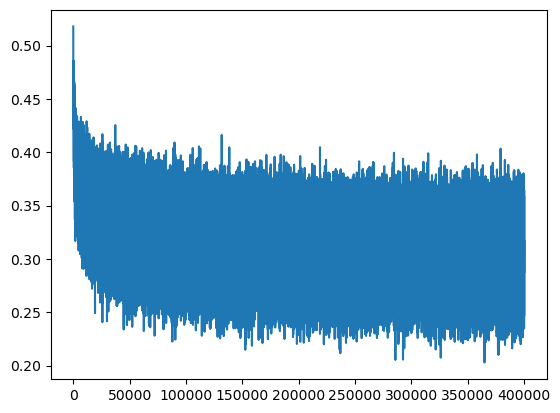

In [18]:
plt.plot(stepi, lossi);

In [19]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * 20) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.091309070587158


The model throughout training seems more flustered/forgetful, with the loss curve oscillating more noticably. Wonder why that is.<br>
At a weight decay of $1e-4$, the validation loss was $2.12$. We can do better.<br>
I pushed back the learning rate scheduling steps by increasing the step factors by $0.1$ each, dropping the validation loss to $2.09$.

<center>Notebook by <a href="https://github.com/mk2112" target="_blank">mk2112</a>.</center>